In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, LeaveOneOut, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import linear_model, svm

from itertools import combinations

# Exploring covariance between properties across scales
**Authors**: Benjamin Jasperson, Harley T. Johnson

**GitHub URL**: https://github.com/bjasperson/property-covariance-demo

# Background Information

why
compromise on modeling: accuracy/first-principles vs. speed and domain size.

what

goals

We're interested in uncovering relationships between fundamental microscopic properties and GB energy.
Desire a scalar value to compare against.
Derived a scaling coefficient.
For purposes here, you don't need to worry about how this coefficient is defined (see the paper for details).

# Download Data
To begin, we need to import our project data.
Collecting this data ....

The data we will use is originally from (this manuscript)[https://arxiv.org/abs/2411.16770], (published here)[https://doi.org/10.1016/j.actamat.2025.120722].

Download the CSV file and look at the first five rows.

In [3]:
url_link = "https://github.com/bjasperson/property-covariance-demo/blob/main/data/gb_data.csv?raw=true"
df_data = pd.read_csv(url_link)
df_data.head()

,Unnamed: 0,crystal_type,species,model,lattice_constant_bcc,lattice_constant_fcc,lattice_constant_sc,bulk_modulus_bcc,bulk_modulus_fcc,bulk_modulus_sc,...,unrelaxed_formation_potential_energy_fcc,unrelaxed_formation_potential_energy_hcp,vacancy_migration_energy_bcc,vacancy_migration_energy_fcc,vacancy_migration_energy_hcp,vacancy_migration_energy_sc,relaxation_volume_bcc,relaxation_volume_fcc,relaxation_volume_hcp,coeff
0,0,fcc,Al,Sim_LAMMPS_MEAM_PascuetFernandez_2015_AlU__SM_...,3.270778,4.049999,2.740228,54.825677,78.890189,46.023445,...,1.058020,NaN,NaN,0.610757,NaN,NaN,NaN,4.683538,NaN,1.191668
1,1,fcc,Al,Sim_LAMMPS_MEAM_PascuetFernandez_2015_Al__SM_8...,3.270778,4.049999,2.740228,54.825677,78.890189,46.023445,...,1.058020,NaN,NaN,0.610485,NaN,NaN,NaN,4.681808,NaN,1.191794
2,2,fcc,Al,Sim_LAMMPS_MEAM_AlmyrasSangiovanniSarakinos_20...,3.252540,4.047000,2.581950,71.601330,79.371087,61.759057,...,1.383830,NaN,NaN,0.573611,NaN,NaN,NaN,5.431662,NaN,0.691561
3,3,fcc,Al,Sim_LAMMPS_MEAM_JelinekGrohHorstemeyer_2012_Al...,3.205723,4.049999,2.702319,81.620977,77.446258,51.141824,...,0.841906,NaN,NaN,0.496487,NaN,NaN,NaN,5.362940,NaN,1.134840
4,4,fcc,Al,EAM_Dynamo_AngeloMoodyBaskes_1995_NiAlH__MO_41...,3.367689,4.050000,2.705041,83.092686,79.372122,86.368413,...,0.746775,NaN,NaN,0.179855,NaN,NaN,NaN,5.521970,NaN,0.495295


# Data review
It is important to get a feel for the data that you are working with. 


**Task**: explore different combinations of pairplots for the data. Identify any possible outliers for removal.

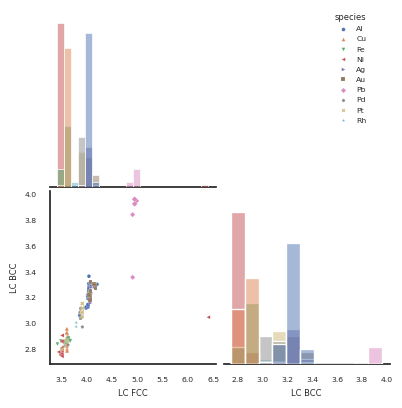

In [4]:
def pairplot_fun(df, 
                 params_list,  
                 label_dict, 
                 xlims = False, 
                 height=2.0):
    """create pairplot for select indicator properties

    Args:
        df (pandas.DataFrame): dataframe of data
        params_list (list): list of parameter strings to use
        label_dict (dict): convert label keys to human readable format
        xlims (list): list of limits to use for plotting
        height (float): pairplot height
    """
    params_list.extend(['species'])
    X = df[params_list]
    X.columns = [label_dict[x] for x in X.columns.to_list()]
    sns.set_theme(style="white", font_scale = .5)
    marker_list = ['o','^','v','<','>','s','D','p','X','*','.','P']
    g = sns.pairplot(X, hue='species', corner=True, markers = marker_list[0:len(df.species.drop_duplicates())],
                     plot_kws=dict(s=7, linewidth=0.1, rasterized = True), 
                     height=height,
                     diag_kind='hist')
    sns.move_legend(g, "upper right", bbox_to_anchor = (0.85,1))

    if xlims != False:
        for i in range(len(g.axes)):
            for j in range(len(g.axes[i])):
                g.axes[i][j].set_xlim(xlims)
                g.axes[i][j].set_ylim(xlims)


def import_label_dict():
    df_label_dict = pd.read_csv("./data/label_dict.csv")
    label_dict = df_label_dict.to_dict(orient="records")[0]
    return label_dict

label_dict = import_label_dict()
plot_param_list = ["lattice_constant_fcc", "lattice_constant_bcc"]
pairplot_fun(df_data, plot_param_list, label_dict)

# Identifying indicator properties

**Task**: run K-fold cross-validation. 

# Develop regression model

Linear regression versus SVR.

In [5]:
def factor_select_cv(X, y, pipe, n_factor_max=2, cv=5, scoring='r2'):
    """return list of parameters w/ cv score
    """
    factor_list = X.columns.to_list()
    subsets = []
    for n in range(1, (n_factor_max+1)):
        for subset in combinations(factor_list, n):
            subsets.append(list(subset))

    cv_score_mean = []
    cv_score_std = []
    num_factors = []
    for i, subset in enumerate(subsets):
        print(f"{i} of {len(subsets)}")
        print('current subset: ', subset)
        score = cross_val_score(pipe, X[subset], y, cv=cv, scoring=scoring, n_jobs = -1)
        print('score mean: ', np.mean(score))
        cv_score_mean.append(np.mean(score))
        cv_score_std.append(np.std(score))
        num_factors.append(len(subset))

    df_results = pd.DataFrame({'factors': subsets,
                               'num_factors': num_factors,
                               'cv_score': cv_score_mean,
                               'cv_score_std': cv_score_std})
    df_results = df_results.sort_values('cv_score', ascending=False)

    return df_results

In [9]:
params_list = ['lattice_constant_fcc',
                'bulk_modulus_fcc', 'c11_fcc', 'c12_fcc', 'c44_fcc',
                'extr_stack_fault_energy_fcc'
                ]

In [12]:
imput = KNNImputer(n_neighbors=2, weights="uniform",
                    keep_empty_features=True)

# Linear regression selection pipeline, used in manuscript
imput = KNNImputer(n_neighbors=2, weights="uniform",
                keep_empty_features=True)
model = linear_model.LinearRegression()

pipe = Pipeline(steps=[('scale', StandardScaler()),
                        ('imp', imput),
                        ('lr', model)])
pipe = TransformedTargetRegressor(regressor=pipe,
                                transformer=StandardScaler())
filename = "kfold_models_lr"

X = df_data[params_list]
y = df_data['coeff']

n_factor_max = 2

cv = RepeatedKFold(n_splits=10, n_repeats=5)
df_results = factor_select_cv(X, 
                              y, 
                              pipe, 
                              n_factor_max=n_factor_max, 
                              cv=cv, 
                              scoring='neg_root_mean_squared_error')

#df_results.to_csv("./gb_covariance/model_ays/"+filename+".csv")

#factor_percent_usage(df_results, 100, filename)

0 of 21
current subset:  ['lattice_constant_fcc']
score mean:  -0.472551317361107
1 of 21
current subset:  ['bulk_modulus_fcc']
score mean:  -0.4533472541908171
2 of 21
current subset:  ['c11_fcc']
score mean:  -0.4589903430270457
3 of 21
current subset:  ['c12_fcc']
score mean:  -0.46859228991332763
4 of 21
current subset:  ['c44_fcc']
score mean:  -0.36529406171742496
5 of 21
current subset:  ['extr_stack_fault_energy_fcc']
score mean:  -0.7745551225153696
6 of 21
current subset:  ['lattice_constant_fcc', 'bulk_modulus_fcc']
score mean:  -0.38935616416313457
7 of 21
current subset:  ['lattice_constant_fcc', 'c11_fcc']
score mean:  -0.3912166955385152
8 of 21
current subset:  ['lattice_constant_fcc', 'c12_fcc']
score mean:  -0.3997821389065644
9 of 21
current subset:  ['lattice_constant_fcc', 'c44_fcc']
score mean:  -0.3590591778344497
10 of 21
current subset:  ['lattice_constant_fcc', 'extr_stack_fault_energy_fcc']
score mean:  -0.542606497812659
11 of 21
current subset:  ['bulk_modu

In [16]:
df_results.sort_values("cv_score", ascending=False)

,factors,num_factors,cv_score,cv_score_std
18,"[c12_fcc, c44_fcc]",2,-0.343827,0.124234
13,"[bulk_modulus_fcc, c44_fcc]",2,-0.346450,0.134632
9,"[lattice_constant_fcc, c44_fcc]",2,-0.359059,0.114780
16,"[c11_fcc, c44_fcc]",2,-0.360966,0.140167
4,[c44_fcc],1,-0.365294,0.114106
6,"[lattice_constant_fcc, bulk_modulus_fcc]",2,-0.389356,0.099862
7,"[lattice_constant_fcc, c11_fcc]",2,-0.391217,0.122904
8,"[lattice_constant_fcc, c12_fcc]",2,-0.399782,0.082416
20,"[c44_fcc, extr_stack_fault_energy_fcc]",2,-0.423801,0.207984
1,[bulk_modulus_fcc],1,-0.453347,0.102659


# Make predictions from first-principles indicator properties

Import DFT data. 

Look at the DFT properties available and select the best 3 to make a model from.

In [17]:
url_link = "https://github.com/bjasperson/property-covariance-demo/blob/main/data/gb_dft.csv?raw=true"
df_dft = pd.read_csv(url_link)
df_dft.head()

HTTPError: HTTP Error 404: Not Found

In [ ]:
# best model of the 5 available DFT properties
model_properties = ['c44_fcc', 
                    'intr_stack_fault_energy_fcc', 
                    'unstable_stack_energy_fcc']

In [ ]:
X_df = df_ip[model_properties]
y = df_ip['coeff']
X = X_df[model_properties]